In [1]:
%matplotlib inline

In [2]:
from collections import namedtuple
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
# set some seaborn aesthetics
sbn.set_palette("Set1")

In [4]:
# initialize random seed for reproducibility
np.random.seed(20160404)

## Sums of squares functions

Let's start by writing a set of functions for calculating sums of squared deviations from the mean (also called "sums of squared differences"), or "sums-of-squares" for short.

In [5]:
def sum_squares_total(groups):
    """Calculate total sum of squares ignoring groups.
    
    groups should be a sequence of np.arrays representing the samples asssigned 
    to their respective groups.
    """
    allobs = np.ravel(groups)  # np.ravel collapses arrays or lists into a single list
    grandmean = np.mean(allobs)
    return np.sum((allobs - grandmean)**2)
    

def sum_squares_between(groups):
    """Between group sum of squares"""
    ns = np.array([len(g) for g in groups])
    grandmean = np.mean(np.ravel(groups))
    groupmeans = np.array([np.mean(g) for g in groups])
    return np.sum(ns * (groupmeans - grandmean)**2)


def sum_squares_within(groups):
    """Within group sum of squares"""
    groupmeans = np.array([np.mean(g) for g in groups])
    group_sumsquares = []
    for i in range(len(groups)):
        groupi = np.asarray(groups[i])
        groupmeani = groupmeans[i]
        group_sumsquares.append(np.sum((groupi - groupmeani)**2))
    return np.sum(group_sumsquares)
        
    
def degrees_freedom(groups):
    """Calculate the """
    N = len(np.ravel(groups))
    k = len(groups)
    return (k-1, N - k, N - 1)

In [6]:
def ANOVA_oneway(groups):
    index = ['BtwGroup', 'WithinGroup', 'Total']
    cols = ['df', 'SumSquares','MS','F','pval']
    
    df   = degrees_freedom(groups)
    ss   = sum_squares_between(groups), sum_squares_within(groups), sum_squares_total(groups)
    ms   = ss[0]/df[0], ss[1]/df[1], ""
    F    = ms[0]/ms[1], "", ""
    pval = stats.f.sf(F[0], df[0], df[1]), "", ""
    
    tbl = pd.DataFrame(index=index, columns=cols)
    tbl.index.name = 'Source'
    tbl.df = df
    tbl.SumSquares = ss
    tbl.MS = ms
    tbl.F = F
    tbl.pval = pval
    
    return tbl
    
def ANOVA_R2(anovatbl):
    SSwin = anovatbl.SumSquares[1]
    SStot = anovatbl.SumSquares[2]
    return (1.0 - (SSwin/SStot))

## Simulate ANOVA under the null hypothesis of no difference in group means

In [7]:
## simulate one way ANOVA under the null hypothesis of no 
## difference in group means

groupmeans = [0, 0, 0, 0]
k = len(groupmeans) # number of groups
groupstds = [1] * k  # standard deviations equal across groups
n = 25 # sample size

# generate samples
samples = [stats.norm.rvs(loc=i, scale=j, size = n) for (i,j) in zip(groupmeans,groupstds)]
allobs = np.concatenate(samples)

Draw a figure to illustrate the within group distributions and the total distribution.

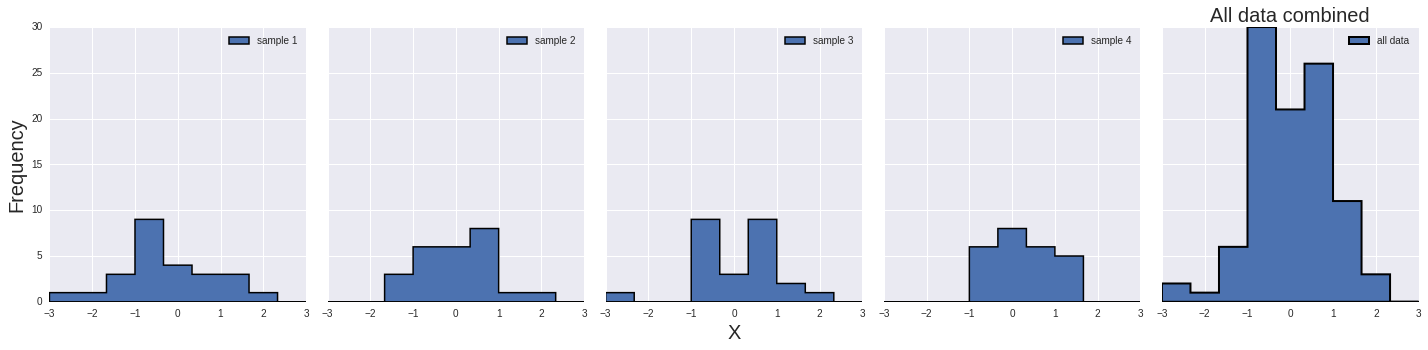

In [8]:
sbn.set_palette("deep")

bins = np.linspace(-3, 3, 10)
fig, axes = plt.subplots(1, 5, figsize=(20,5), sharex=True, sharey=True)

for i, sample in enumerate(samples):
    axes[i].hist(sample, bins=bins, histtype='stepfilled', 
                 linewidth=1.5, label='sample {}'.format(i+1))
    axes[i].legend()

axes[-1].hist(allobs, bins=bins, histtype='stepfilled', linewidth=2, label='all data')
axes[-1].legend()
axes[-1].set_title("All data combined", fontsize=20)

axes[0].set_ylabel("Frequency", fontsize=20)
axes[2].set_xlabel("X", fontsize=20)

fig.tight_layout()
pass

Calculate the sums of squares

In [9]:
SSbtw = sum_squares_between(samples)
SSwin = sum_squares_within(samples)
SStot = sum_squares_total(samples)

print("SS between:", SSbtw)
print("SS within:", SSwin)
print("SS total:", SStot)

SS between: 3.38988403571
SS within: 73.5951590182
SS total: 76.9850430539


Generate ANOVA table:

In [10]:
ANOVA_oneway(samples)

,df,SumSquares,MS,F,pval
Source,,,,,
BtwGroup,3,3.389884,1.12996,1.47396,0.226502
WithinGroup,96,73.595159,0.766616,,
Total,99,76.985043,,,


## Simulating ANOVA under $H_A$

In [11]:
groupmeans = [0, 0, -1, 1]
k = len(groupmeans) # number of groups
groupstds = [1] * k  # standard deviations equal across groups
n = 25 # sample size

# generate samples
samples = [stats.norm.rvs(loc=i, scale=j, size = n) for (i,j) in zip(groupmeans,groupstds)]
allobs = np.concatenate(samples)

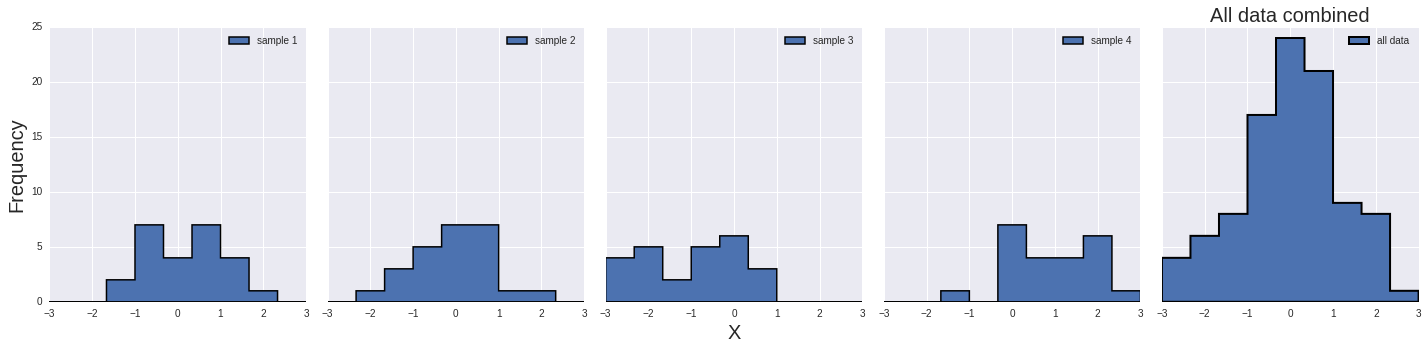

In [12]:
sbn.set_palette("deep")

bins = np.linspace(-3, 3, 10)
fig, axes = plt.subplots(1, 5, figsize=(20,5), sharex=True, sharey=True)

for i, sample in enumerate(samples):
    axes[i].hist(sample, bins=bins, histtype='stepfilled', 
                 linewidth=1.5, label='sample {}'.format(i+1))
    axes[i].legend()

axes[-1].hist(allobs, bins=bins, histtype='stepfilled', linewidth=2, label='all data')
axes[-1].legend()
axes[-1].set_title("All data combined", fontsize=20)

axes[0].set_ylabel("Frequency", fontsize=20)
axes[2].set_xlabel("X", fontsize=20)

fig.tight_layout()
pass

In [13]:
SSbtw = sum_squares_between(samples)
SSwin = sum_squares_within(samples)
SStot = sum_squares_total(samples)

print("SS between:", SSbtw)
print("SS within:", SSwin)
print("SS total:", SStot)

SS between: 58.3506974287
SS within: 103.063491836
SS total: 161.414189265


In [14]:
tbl = ANOVA_oneway(samples)
tbl

,df,SumSquares,MS,F,pval
Source,,,,,
BtwGroup,3,58.350697,19.4502,18.1172,2.14268e-09
WithinGroup,96,103.063492,1.07358,,
Total,99,161.414189,,,


Calculate the value of $R^2$ for our ANOVA model:

In [15]:
ANOVA_R2(tbl)

0.36149670418983804

`scipy.stats` has an `f_oneway` function for calculating the f statistic and assocated p-value for a one-way ANOVA.  Let's compare oure result above to the implementation in `scipy.stats`

In [16]:
# f_oneway expects the samples to be passed in as individual arguments
# this *samples notation "unpacks" the list of samples, treating each as 
# an argument to the function.
# see: https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists

stats.f_oneway(*samples)

F_onewayResult(statistic=18.117204108393736, pvalue=2.1426767523356996e-09)

# Anderson's Iris Data revisited

In [17]:
irisurl = "https://raw.githubusercontent.com/Bio204-class/bio204-datasets/master/iris.csv"
iris = pd.read_csv(irisurl)

In [18]:
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


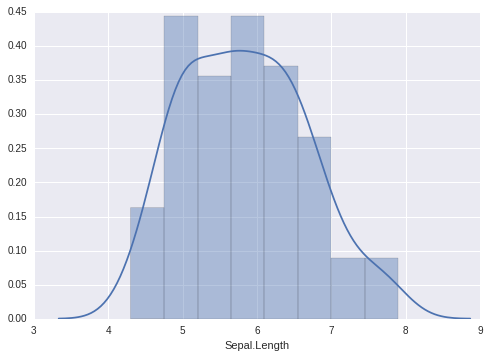

In [19]:
sbn.distplot(iris["Sepal.Length"])
pass

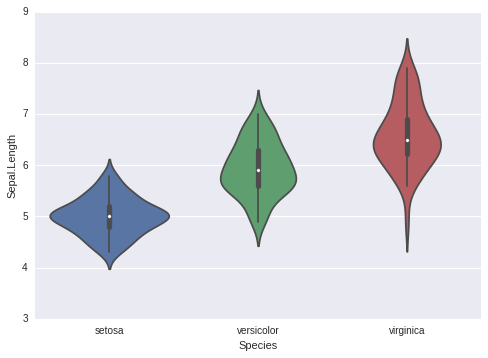

In [20]:
sbn.violinplot(x="Species", y="Sepal.Length", data=iris)
pass

In [21]:
setosa = iris[iris.Species =='setosa']
versicolor = iris[iris.Species=='versicolor']
virginica = iris[iris.Species == 'virginica']

In [22]:
ANOVA_oneway([setosa['Sepal.Length'], versicolor['Sepal.Length'],
            virginica['Sepal.Length']])

,df,SumSquares,MS,F,pval
Source,,,,,
BtwGroup,2,63.212133,31.6061,119.265,1.66967e-31
WithinGroup,147,38.956200,0.265008,,
Total,149,102.168333,,,
